# Move global forcing files to regional domain with new bathymetry

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/users/birgal/')
from nemo_python.ics_obcs import fill_ocean
from nemo_python.interpolation import neighbours

#### Functions

In [13]:
def subset_global(file_path, nemo_mask, fill_ocn=False):

    ds = xr.open_dataset(f'{file_path}').isel(y=slice(0,453))

    if fill_ocn:
        for var in list(ds.keys()):
            ds[var] = xr.where(np.isnan(ds[var]), ds[var].mean(), ds[var])
        #     # Check for values that are NaN and in the ocean
        #     # cond      = (mesh_new.tmask.isel(time_counter=0, nav_lev=0) == 1)*np.isnan(ds[var]) 
        #     ds_filled = fill_ocean(ds.isel(time_counter=0), var, nemo_mask)
    
    new_file_path = file_path.replace(file_path.split('/')[-1], f"AntArc_{file_path.split('/')[-1]}") 
    ds.to_netcdf(f"{new_file_path}")
    
    return ds

In [ ]:
# sum(sum(np.isnan(iwm_ds.isel(y=slice(0,453), time_counter=0).values)))

In [ ]:
# iwm_powerbot_filled = fill_ocean(iwm_ds.isel(y=slice(0,453), time_counter=0), 'power_bot', mesh_new)

### Main

In [4]:
domain_old   = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-old.nc')
domain_new   = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20231025-filledlakes.nc')
mesh_new     = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20231025-filledlakes.nc')

In [14]:
folder      = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/misc-forcing/'
subset_global(f'{folder}eORCA025_iwm_b0.2_v1.0_nohls.nc', mesh_new, fill_ocn=True)

<xarray.DataArray 'power_bot' ()>
array(9.0439884e-05, dtype=float32)
<xarray.DataArray 'power_cri' ()>
array(0.00158126, dtype=float32)
<xarray.DataArray 'power_nsq' ()>
array(0.00040086, dtype=float32)
<xarray.DataArray 'power_sho' ()>
array(5.2325453e-05, dtype=float32)
<xarray.DataArray 'scale_bot' ()>
array(80409.22, dtype=float32)
<xarray.DataArray 'scale_cri' ()>
array(353.03537, dtype=float32)


<xarray.Dataset>
Dimensions:       (y: 453, x: 1440, time_counter: 1)
Coordinates:
    glamt         (y, x) float64 ...
    gphit         (y, x) float64 ...
  * time_counter  (time_counter) float64 0.0
Dimensions without coordinates: y, x
Data variables:
    power_bot     (time_counter, y, x) float32 9.044e-05 9.044e-05 ... 0.0001165
    power_cri     (time_counter, y, x) float32 0.001581 0.001581 ... 0.002986
    power_nsq     (time_counter, y, x) float32 0.0004009 0.0004009 ... 0.002318
    power_sho     (time_counter, y, x) float32 5.233e-05 5.233e-05 ... 9.395e-05
    scale_bot     (time_counter, y, x) float32 8.041e+04 8.041e+04 ... 5.775e+03
    scale_cri     (time_counter, y, x) float32 353.0 353.0 353.0 ... 353.0 111.2
Attributes:
    Info:                       Horizontal grid read in eORCA025_coord_c3.0.n...
    About:                      Created with SOSIE interpolation environement...
    history:                    Fri Jul  1 12:18:37 2022: ncks -d x,1,1440 -d...
    NCO:                        netCDF Operators version 4.9.1 (Homepage = ht...
    history_of_appended_files:  Fri Jun 17 16:28:35 2022: Appended file eORCA...

In [ ]:
# Load global files
folder      = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/misc-forcing/'
files_coast = ['eORCA025_calving_b0.2_v2.3_nohls.nc', 'eORCA025_distcoast_b0.2_v0.0_nohls.nc', 
               'eORCA025_runoff_b0.2_v0.0_nohls.nc']
# mv_ocn   = ~fill_ocn # move values from land to the nearest ocean point
# mv_to_coast = fill_ocn # move non-zero values to the new land-edge

# subset files:
# - internal wave field --- fill with connected nearest neighbour
subset_global(f'{folder}eORCA025_iwm_b0.2_v1.0_nohls.nc', mesh_new, fill_ocn=True)
# - bottom friction  / turbulence --- leave as zeros
subset_global(f'{folder}eORCA025_shlat2d_v0.2_nohls.nc' , mesh_new, fill_ocn=False)
subset_global(f'{folder}eORCA025_bfr2d_v0.2_nohls.nc'   , mesh_new, fill_ocn=False)
# - distance to the coast --- recalculate for new bathymetry
# - runoff --- use list of first point in the ocean to move runoff to this cell 
#             (don't need to do in this case because I'm not running with runoff)
# - calving --- check that these are close enough to the iceshelf edge to be fine:
#               check distcoast to first point on land at each point where calving happens
#               if distcoast=0 (on land) where calving is nonzero, move the calving to the nearest point where distcoast!=0 and check that imask nearby
#               if calving is nonzero and distcoast > 10 km (or some other value), move the calving closer to the coastline

Filling gaps with connected nearest neighbours


  0%|          | 0/100 [00:00<?, ?it/s]

650833


  1%|          | 1/100 [00:15<25:28, 15.44s/it]

612075


In [161]:
calving = xr.open_dataset(f'{folder}eORCA025_calving_b0.2_v2.3_nohls.nc').isel(time_counter=0, y=slice(0,453))

In [7]:
x_plot, y_plot = np.meshgrid(mesh_new.x, mesh_new.y)
calving_p = np.ma.masked_where(calving.soicbclv.values==0, calving.soicbclv.values)
calving_x = np.ma.masked_where(calving.soicbclv.values==0, x_plot)
calving_y = np.ma.masked_where(calving.soicbclv.values==0, y_plot)

In [33]:
# Helper function to calculate the Cartesian distance between two longitude and latitude points
# This also works if one of point0, point1 is a 2D array.
from nemo_python.constants import deg2rad, rEarth


def distance_btw_points (point0, point1):
    
    [lon0, lat0] = point0
    [lon1, lat1] = point1
    
    dx = rEarth*np.cos((lat0+lat1)/2*deg2rad)*(lon1-lon0)*deg2rad
    dy = rEarth*(lat1-lat0)*deg2rad
    
    return np.sqrt(dx**2 + dy**2)

In [75]:
icefront_mask_coord = (mesh_new.nav_lon.values[icefront_mask_ocn], 
                       mesh_new.nav_lat.values[icefront_mask_ocn])

In [35]:
calving_ocn, calving_land, calving_ice = calving_at_coastline(calving.soicbclv, mesh_new)

In [117]:
calving_new = calving.soicbclv.values

In [113]:
print(mesh_new.nav_lon.values.shape)
print(index)

(453, 1440)
(495, 158)


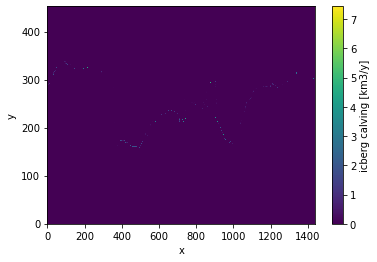

In [163]:
calving.soicbclv.plot()

In [164]:
calving.soicbclv.isel(x=slice(918,921), y=slice(209,212))

<xarray.DataArray 'soicbclv' (y: 3, x: 3)>
array([[0.      , 0.295276, 2.566219],
       [1.078929, 3.597189, 0.      ],
       [4.117537, 0.      , 0.      ]], dtype=float32)
Dimensions without coordinates: y, x
Attributes:
    units:             km3/y
    valid_min:         0.0
    valid_max:         2000.0
    long_name:         icberg calving
    short_name:        soicbclv
    iweight:           1
    online_operation:  N/A
    axis:              TYX
    savelog10:         0.0

In [186]:
x, y = np.meshgrid(mesh_new.nav_lon.x, mesh_new.nav_lon.y)

calving_ocn_x = x[(~np.isnan(calving_ocn))]
calving_ocn_y = y[(~np.isnan(calving_ocn))]

icefront_x     = x[icefront_mask_ocn]
icefront_y     = y[icefront_mask_ocn]
icefront_coord = (mesh_new.nav_lon.values[icefront_mask_ocn], 
                  mesh_new.nav_lat.values[icefront_mask_ocn])

# calving_new = calving.soicbclv.values
calving_new    = np.empty(calving.soicbclv.values.shape)
calving_new[:] = np.nan

for index in list(zip(calving_ocn_y, calving_ocn_x)):

    calving_coord = (mesh_new.nav_lon.values[index], mesh_new.nav_lat.values[index])
    distances = distance_btw_points(calving_coord, icefront_coord)

    if np.min(np.abs(distances)) > 11000: # coordinate of nearest icefront ocean point
        # Index coordinates of nearest point:
        new_x_ind = icefront_x[np.argmin(np.abs(distances))]
        new_y_ind = icefront_y[np.argmin(np.abs(distances))]
        # Move calving to the nearest icefront point
        calving_new[new_y_ind, new_x_ind] = calving.soicbclv.values[index]
        # calving_new[index] = np.nan 

In [187]:
coast_mask        = get_coast_mask(mesh_new)
icefront_mask_ice = get_icefront_mask(mesh_new, side='ice')
icefront_mask_ocn = get_icefront_mask(mesh_new, side='ocean')

In [34]:
calving_nonocnx = np.ma.masked_where(icefront_mask_ocn, calving_x)
calving_nonocny = np.ma.masked_where(icefront_mask_ocn, calving_y)
# identify non-zero calving points that are not icefront_mask_ocn 
# check whether these points are ocean points
# ---> true: check whether within 1-2 grid cell range of coastline --> if that's true keep as is, else move to within closer distance to the coastline
# ---> false: if point is in icefront_mask_ice, move to the nearest icefront_mask_ocn point. 
#             if point is in coast_mask, move to nearest icefront_mask_ocn point


def calving_at_coastline(calving, mask):

    calving   = xr.where(calving > 0, calving, np.nan)

    # Boolean arrays to identify regions:
    ocean     = (mask.tmask.isel(time_counter=0, nav_lev=0) == 1)
    iceshelf  = (mask.tmaskutil.isel(time_counter=0) - mask.tmask.isel(time_counter=0, nav_lev=0)).astype(bool);
    land      = (mask.tmaskutil.isel(time_counter=0) == 0)

    # Cases where calving does not occur at the ocean edge of the icefront:
    calving_ocn  = xr.where((~icefront_mask_ocn & ocean), calving, np.nan)  
    calving_land = xr.where(land      , calving, np.nan)  # calving occurs on land
    calving_ice  = xr.where(iceshelf  , calving, np.nan)  # calving occurs on ice shelf

    # For calving in ocean, check distance to nearest coastline with iceshelf
    # distance_btw_points()
    
    # Move to nearest ocean point:

    return calving_ocn, calving_land, calving_ice


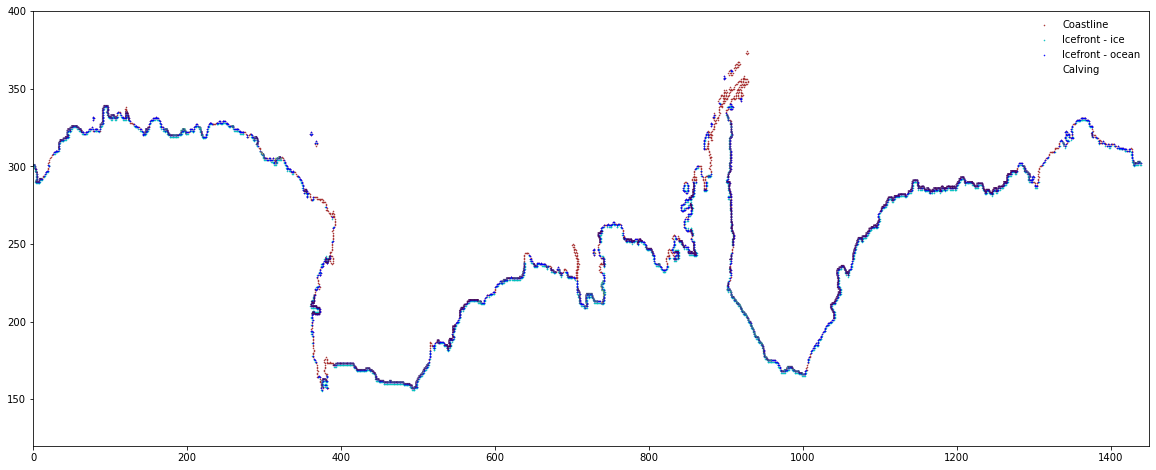

In [23]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
ax.set_xlim(0,1450)
ax.set_ylim(120,400)

x_plot, y_plot = np.meshgrid(mesh_new.x, mesh_new.y)
coast_x  = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, x_plot); coast_y = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, y_plot);
isfice_x = np.ma.masked_where(icefront_mask_ice == 0, x_plot); isfice_y = np.ma.masked_where(icefront_mask_ice == 0, y_plot);
isfocn_x = np.ma.masked_where(icefront_mask_ocn == 0, x_plot); isfocn_y = np.ma.masked_where(icefront_mask_ocn == 0, y_plot);
ax.scatter(coast_x, coast_y, c='brown', s=0.3, label='Coastline');
ax.scatter(isfice_x, isfice_y, c='c', s=0.3, label='Icefront - ice');
ax.scatter(isfocn_x, isfocn_y, c='b', s=0.3, label='Icefront - ocean');
ax.scatter(calving_x, calving_y, c=calving_p, s=0.3, label='Calving')

ax.legend(frameon=False)

In [188]:
calving_newx = np.ma.masked_where(np.isnan(calving_new), calving_x)
calving_newy = np.ma.masked_where(np.isnan(calving_new), calving_y)

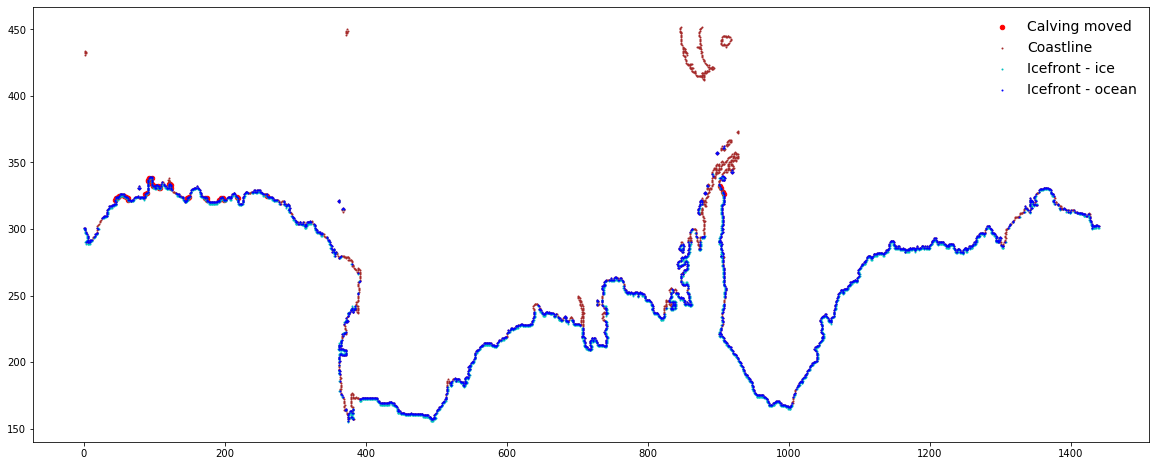

In [193]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
# ax.set_xlim(1100,1200)
# ax.set_ylim(265,300)

x_plot, y_plot = np.meshgrid(mesh_new.x, mesh_new.y)
coast_x  = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, x_plot); coast_y = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, y_plot);
isfice_x = np.ma.masked_where(icefront_mask_ice == 0, x_plot); isfice_y = np.ma.masked_where(icefront_mask_ice == 0, y_plot);
isfocn_x = np.ma.masked_where(icefront_mask_ocn == 0, x_plot); isfocn_y = np.ma.masked_where(icefront_mask_ocn == 0, y_plot);
# ax.scatter(calving_nonocnx, calving_nonocny, c='w', s=10, edgecolor='k', label='Calving');
ax.scatter(calving_newx   , calving_newy   , c='r', s=20, edgecolor='r', label='Calving moved');
ax.scatter(coast_x , coast_y, c='brown', s=1, label='Coastline');
ax.scatter(isfice_x, isfice_y, c='c', s=1, label='Icefront - ice');
ax.scatter(isfocn_x, isfocn_y, c='b', s=1, label='Icefront - ocean');

ax.legend(frameon=False, fontsize=14)

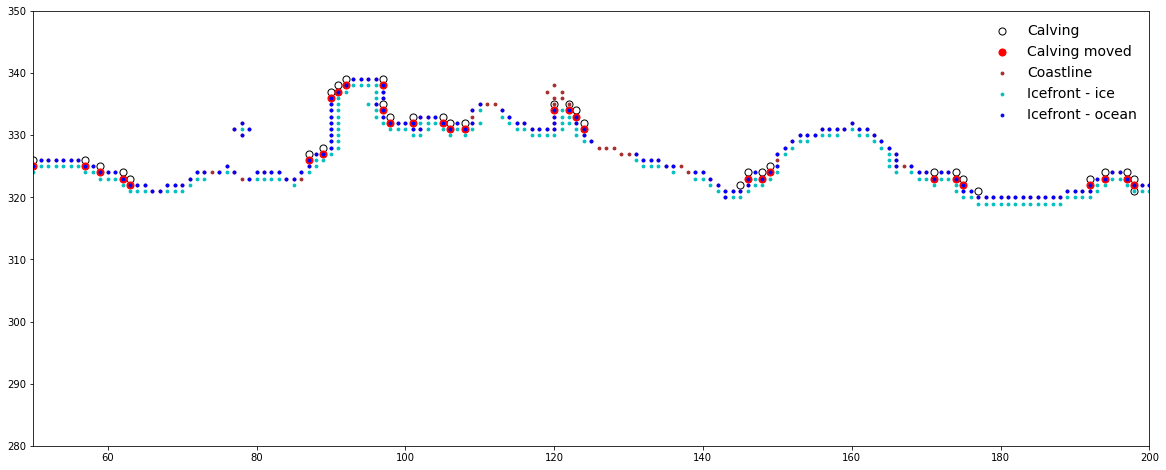

In [194]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
ax.set_xlim(50,200)
ax.set_ylim(280,350)

x_plot, y_plot = np.meshgrid(mesh_new.x, mesh_new.y)
coast_x  = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, x_plot); coast_y = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, y_plot);
isfice_x = np.ma.masked_where(icefront_mask_ice == 0, x_plot); isfice_y = np.ma.masked_where(icefront_mask_ice == 0, y_plot);
isfocn_x = np.ma.masked_where(icefront_mask_ocn == 0, x_plot); isfocn_y = np.ma.masked_where(icefront_mask_ocn == 0, y_plot);
ax.scatter(calving_nonocnx, calving_nonocny, c='w', s=50, edgecolor='k', label='Calving');
ax.scatter(calving_newx   , calving_newy   , c='r', s=50, edgecolor='r', label='Calving moved');
ax.scatter(coast_x , coast_y, c='brown', s=8, label='Coastline');
ax.scatter(isfice_x, isfice_y, c='c', s=8, label='Icefront - ice');
ax.scatter(isfocn_x, isfocn_y, c='b', s=8, label='Icefront - ocean');

ax.legend(frameon=False, fontsize=14)

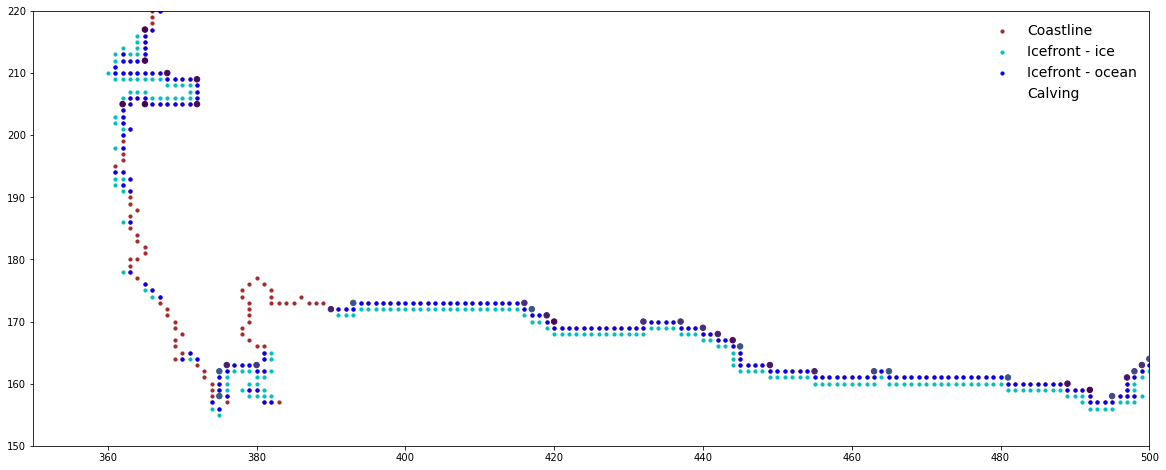

In [29]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
ax.set_xlim(350,500)
ax.set_ylim(150,220)

x_plot, y_plot = np.meshgrid(mesh_new.x,'r' mesh_new.y)
coast_x  = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, x_plot); coast_y = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, y_plot);
isfice_x = np.ma.masked_where(icefront_mask_ice == 0, x_plot); isfice_y = np.ma.masked_where(icefront_mask_ice == 0, y_plot);
isfocn_x = np.ma.masked_where(icefront_mask_ocn == 0, x_plot); isfocn_y = np.ma.masked_where(icefront_mask_ocn == 0, y_plot);
ax.scatter(coast_x, coast_y, c='brown', s=10, label='Coastline');
ax.scatter(isfice_x, isfice_y, c='c', s=10, label='Icefront - ice');
ax.scatter(isfocn_x, isfocn_y, c='b', s=10, label='Icefront - ocean');
ax.scatter(calving_nonocnx, calving_nonocny, c=calving_p, s=30, label='Calving');

ax.legend(frameon=False, fontsize=14)

In [10]:
# Build and return a T grid mask for coastal points: open-ocean points with at least one neighbour that is land or ice shelf.
def get_coast_mask(mask):
    
    open_ocean = (mask.tmask.isel(time_counter=0) == 1)
    land_ice   = ~open_ocean
    
    num_coast_neighbours = neighbours(land_ice, missing_val=0)[-1]
    coast_mask           = (open_ocean*(num_coast_neighbours > 0)).astype(bool)
    
    return coast_mask

In [11]:
# Build and return a 2D mask for the ice shelf front points of the given ice shelf.
def get_icefront_mask(mask, side='ice'):

    # mask of iceshelves (true for iceshelf, false otherwise)
    # isf  = (mesh_new.misf.isel(time_counter=0) > 0) & (mesh_new.tmask.isel(time_counter=0, nav_lev=0) == 0)
    ice_shelf  = (mask.tmaskutil.isel(time_counter=0) - mask.tmask.isel(time_counter=0, nav_lev=0)).astype(bool)
    open_ocean = (mask.tmask.isel(time_counter=0, nav_lev=0) == 1)

    if side == 'ice':
        # Return ice shelf points with at least 1 open-ocean neighbour
        num_open_ocean_neighbours = neighbours(open_ocean, missing_val=0)[-1]
        
        return (ice_shelf*(num_open_ocean_neighbours > 0)).astype(bool)
    elif side == 'ocean':
        # Return ocean points with at least 1 ice shelf neighbour
        num_ice_shelf_neighbours = neighbours(ice_shelf, missing_val=0)[-1]
        
        return (open_ocean*(num_ice_shelf_neighbours > 0)).astype(bool)

In [19]:
# https://benalexkeen.com/implementing-djikstras-shortest-path-algorithm-with-python/
# https://towardsdatascience.com/compute-the-distance-matrix-of-a-set-of-sites-from-their-coordinates-in-python-d5fc92a0ba9e